In [2]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
from pathlib import Path

folder_path = Path("/mnt/truenas_users/ChenHongliang/RPT-master/")

# 递归遍历所有.csv文件
for csv_file in folder_path.rglob("*.csv"):
    print(csv_file)  # 输出文件路径对象
    # 可以直接用 csv_file 操作文件（例如 csv_file.read_text()）


/mnt/truenas_users/ChenHongliang/RPT-master/ft_output_dir/20250320_205016_RADTR_YOLO_tiny_finetune_eval/RAD-RAD Boxes AP.csv
/mnt/truenas_users/ChenHongliang/RPT-master/ft_output_dir/20250320_183905_RADTR_YOLO_tiny_finetune_eval/RAD-RAD Boxes AP.csv
/mnt/truenas_users/ChenHongliang/RPT-master/ft_output_dir/20250320_193248_RADTR_YOLO_tiny_finetune_eval/RAD-RAD Boxes AP.csv


In [4]:
class KRadarDataset(Dataset):
    def __init__(self, root_dir, dataset_type='train', transform=None):
        """
        参数:
            root_dir (str): 数据集根目录路径（包含train/val/test的目录）
            dataset_type (str): 数据集类型 ['train', 'val', 'test']
            transform (callable): 可选的数据预处理
        """
        self.root = os.path.join(root_dir, dataset_type)
        self.transform = transform
        self.samples = []
        
        # 遍历场景目录（如1, 2, 3等）
        for scene in sorted(os.listdir(self.root)):
            scene_path = os.path.join(self.root, scene)
            if os.path.isdir(scene_path):
                # 遍历样本目录（如00033_00001）
                for sample in sorted(os.listdir(scene_path)):
                    sample_path = os.path.join(scene_path, sample)
                    if os.path.isdir(sample_path):
                        # 收集所有文件路径
                        sample_files = {
                            'dar': os.path.join(sample_path, 'DAR.npy'),
                            'ra': os.path.join(sample_path, 'ra.npy'),
                            'mono': os.path.join(sample_path, 'mono.jpg'),
                            'stereo': os.path.join(sample_path, 'stereo.jpg'),
                            'labels': os.path.join(sample_path, 'labels.npy'),
                            'radar_labels': os.path.join(sample_path, 'radarlabels.npy')
                        }
                        # 验证文件存在性
                        if all(os.path.isfile(f) for f in sample_files.values()):
                            self.samples.append(sample_files)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # 加载雷达数据
        dar = np.load(sample['dar'])
        ra = np.load(sample['ra'])
        
        # 加载图像数据
        mono_img = Image.open(sample['mono']).convert('RGB')
        stereo_img = Image.open(sample['stereo']).convert('RGB')
        
        # 加载标签
        labels = np.load(sample['labels'])
        radar_labels = np.load(sample['radar_labels'])
        
        # 应用预处理
        if self.transform:
            mono_img = self.transform(mono_img)
            stereo_img = self.transform(stereo_img)
        
        # 转换为Tensor
        dar_tensor = torch.from_numpy(dar).float()
        ra_tensor = torch.from_numpy(ra).float()
        labels_tensor = torch.from_numpy(labels).long()
        radar_labels_tensor = torch.from_numpy(radar_labels).long()
        
        return {
            'dar': dar_tensor,
            'ra': ra_tensor,
            'mono_img': mono_img,
            'stereo_img': stereo_img,
            'labels': labels_tensor,
            'radar_labels': radar_labels_tensor
        }
    

In [5]:
import json
import os
import os.path as osp

from typing import Any, Dict

def load_config(file: str) -> Dict:
    """Load a configuration file.

    Arguments:
        file: Path to the configuration file.

    Returns:
        Configuration dictionary.
    """
    with open(file) as f:
        config = json.load(f)

    return config

In [6]:
# Title: RADDet
# Authors: Ao Zhang, Erlik Nowruzi, Robert Laganiere
import numpy
import numpy as np

import matplotlib.pyplot as plt
from sklearn import mixture


################ coordinates transformation ################
def cartesianToPolar(x, y):
    """ Cartesian to Polar """
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return (rho, phi)


def polarToCartesian(rho, phi):
    """ Polar to Cartesian """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)


################ functions of RAD processing ################
def complexTo2Channels(target_array):
    """ transfer complex a + bi to [a, b]"""
    assert target_array.dtype == np.complex64
    ### NOTE: transfer complex to (magnitude) ###
    output_array = getMagnitude(target_array)
    output_array = getLog(output_array)
    return output_array


def getMagnitude(target_array, power_order=2):
    """ get magnitude out of complex number """
    target_array = np.concatenate([target_array.real, target_array.imag],axis=3)
    # target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array

def getMagnitude1(target_array, power_order=2):
    """ get magnitude out of complex number """
    # target_array = np.concatenate([target_array.real, target_array.imag],axis=3)
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array


def getLog(target_array, scalar=1., log_10=True):
    """ get Log values """
    if log_10:
        return scalar * np.log10(target_array + 1.)
    else:
        return target_array


def getSumDim(target_array, target_axis):
    """ sum up one dimension """
    output = np.sum(target_array, axis=target_axis)
    return output


def switchCols(target_array, cols):
    """ switch columns """
    assert isinstance(cols, tuple) or isinstance(cols, list)
    assert len(cols) == 2
    assert np.max(cols) <= target_array.shape[-1] - 1
    cols = np.sort(cols)
    output_axes = []
    for i in range(target_array.shape[-1]):
        if i == cols[0]:
            idx = cols[1]
        elif i == cols[1]:
            idx = cols[0]
        else:
            idx = i
        output_axes.append(idx)
    return target_array[..., output_axes]


def switchAxes(target_array, axes):
    """ switch axes """
    assert isinstance(axes, tuple) or isinstance(axes, list)
    assert len(axes) == 2
    assert np.max(axes) <= len(target_array.shape) - 1
    return np.swapaxes(target_array, axes[0], axes[1])


def norm2Image(array):
    """ normalize to image format (uint8) """
    norm_sig = plt.Normalize()
    img = plt.cm.viridis(norm_sig(array))
    img *= 255.
    img = img.astype(np.uint8)
    return img
    


def toCartesianMask(RA_mask, radar_config, gapfill_interval_num=1):
    """ transfer RA mask to Cartesian mask for plotting """
    output_mask = np.ones([RA_mask.shape[0], RA_mask.shape[0]*2]) * np.amin(RA_mask)
    point_angle_previous = None
    for i in range(RA_mask.shape[0]):
        for j in range(1, RA_mask.shape[1]):
            if RA_mask[i, j] > 0:
                point_range = ((radar_config["range_size"]-1) - i) * \
                                radar_config["range_resolution"]
                point_angle = (j * (2*np.pi/radar_config["azimuth_size"]) - np.pi) / \
                                (2*np.pi*0.5*radar_config["config_frequency"]/ \
                                radar_config["designed_frequency"])
                point_angle_current = np.arcsin(point_angle)
                if point_angle_previous is None:
                    point_angle_previous = point_angle_current
                for point_angle in np.linspace(point_angle_previous, point_angle_current, \
                                                gapfill_interval_num):
                    point_zx = polarToCartesian(point_range, point_angle)
                    new_i = int(output_mask.shape[0] - \
                            np.round(point_zx[0]/radar_config["range_resolution"])-1)
                    new_j = int(np.round((point_zx[1]+50)/radar_config["range_resolution"])-1)
                    output_mask[new_i,new_j] = RA_mask[i, j]
                point_angle_previous = point_angle_current
    return output_mask


def GaussianModel(pcl):
    """ Get the center and covariance from gaussian model. """
    model = mixture.GaussianMixture(n_components=1, covariance_type='full')
    model.fit(pcl)
    return model.means_[0], model.covariances_[0]


################ ground truth manipulation ################
def boxLocationsToWHD(boxes):
    """ Transfer boxes from [x_min, x_max, y_min, y_max, z_min, z_max] to
    [x_center, y_center, z_center, width, height, depth] """
    new_boxes = np.zeros(boxes.shape)
    if len(boxes.shape) == 2:
        assert boxes.shape[-1] == 6
        new_boxes[:, 0] = np.round((boxes[:, 0] + boxes[:, 1]) / 2)
        new_boxes[:, 1] = np.round((boxes[:, 2] + boxes[:, 3]) / 2)
        new_boxes[:, 2] = np.round((boxes[:, 4] + boxes[:, 5]) / 2)
        new_boxes[:, 3] = np.round(boxes[:, 1] - boxes[:, 0])
        new_boxes[:, 4] = np.round(boxes[:, 3] - boxes[:, 2])
        new_boxes[:, 5] = np.round(boxes[:, 5] - boxes[:, 4])
        return new_boxes
    elif len(boxes.shape) == 1:
        assert boxes.shape[0] == 6
        new_boxes[0] = np.round((boxes[0] + boxes[1]) / 2)
        new_boxes[1] = np.round((boxes[2] + boxes[3]) / 2)
        new_boxes[2] = np.round((boxes[4] + boxes[5]) / 2)
        new_boxes[3] = np.round(boxes[1] - boxes[0])
        new_boxes[4] = np.round(boxes[3] - boxes[2])
        new_boxes[5] = np.round(boxes[5] - boxes[4])
        return new_boxes
    else:
        raise ValueError("Wrong input boxes, please check the input")


def iou2d(box_xywh_1, box_xywh_2):
    """ Numpy version of 3D bounding box IOU calculation
    Args:
        box_xywh_1        ->      box1 [x, y, w, h]
        box_xywh_2        ->      box2 [x, y, w, h]"""
    assert box_xywh_1.shape[-1] == 4
    assert box_xywh_2.shape[-1] == 4
    ### areas of both boxes
    box1_area = box_xywh_1[..., 2] * box_xywh_1[..., 3]
    box2_area = box_xywh_2[..., 2] * box_xywh_2[..., 3]
    ### find the intersection box
    box1_min = box_xywh_1[..., :2] - box_xywh_1[..., 2:] * 0.5
    box1_max = box_xywh_1[..., :2] + box_xywh_1[..., 2:] * 0.5
    box2_min = box_xywh_2[..., :2] - box_xywh_2[..., 2:] * 0.5
    box2_max = box_xywh_2[..., :2] + box_xywh_2[..., 2:] * 0.5

    left_top = np.maximum(box1_min, box2_min)
    bottom_right = np.minimum(box1_max, box2_max)
    ### get intersection area
    intersection = np.maximum(bottom_right - left_top, 0.0)
    intersection_area = intersection[..., 0] * intersection[..., 1]
    ### get union area
    union_area = box1_area + box2_area - intersection_area
    ### get iou
    iou = np.nan_to_num(intersection_area / (union_area + 1e-10))
    return iou


def iou3d(box_xyzwhd_1, box_xyzwhd_2, input_size):
    """ Numpy version of 3D bounding box IOU calculation
    Args:
        box_xyzwhd_1        ->      box1 [x, y, z, w, h, d]
        box_xyzwhd_2        ->      box2 [x, y, z, w, h, d]"""
    assert box_xyzwhd_1.shape[-1] == 6
    assert box_xyzwhd_2.shape[-1] == 6
    fft_shift_implement = np.array([0, 0, input_size[2] / 2])
    ### areas of both boxes
    box1_area = box_xyzwhd_1[..., 3] * box_xyzwhd_1[..., 4] * box_xyzwhd_1[..., 5]
    box2_area = box_xyzwhd_2[..., 3] * box_xyzwhd_2[..., 4] * box_xyzwhd_2[..., 5]
    ### find the intersection box
    box1_min = box_xyzwhd_1[..., :3] + fft_shift_implement - box_xyzwhd_1[..., 3:] * 0.5
    box1_max = box_xyzwhd_1[..., :3] + fft_shift_implement + box_xyzwhd_1[..., 3:] * 0.5
    box2_min = box_xyzwhd_2[..., :3] + fft_shift_implement - box_xyzwhd_2[..., 3:] * 0.5
    box2_max = box_xyzwhd_2[..., :3] + fft_shift_implement + box_xyzwhd_2[..., 3:] * 0.5

    #box1_min = box_xyzwhd_1[..., :3] - box_xyzwhd_1[..., 3:] * 0.5
    #box1_max = box_xyzwhd_1[..., :3] + box_xyzwhd_1[..., 3:] * 0.5
    #box2_min = box_xyzwhd_2[..., :3] - box_xyzwhd_2[..., 3:] * 0.5
    #box2_max = box_xyzwhd_2[..., :3] + box_xyzwhd_2[..., 3:] * 0.5

    left_top = np.maximum(box1_min, box2_min)
    bottom_right = np.minimum(box1_max, box2_max)
    ### get intersection area
    intersection = np.maximum(bottom_right - left_top, 0.0)
    intersection_area = intersection[..., 0] * intersection[..., 1] * intersection[..., 2]
    ### get union area
    union_area = box1_area + box2_area - intersection_area
    ### get iou
    iou = np.nan_to_num(intersection_area / (union_area + 1e-10))
    return iou


def giou3d(box_xyzwhd_1, box_xyzwhd_2):
    """ Numpy version of 3D bounding box GIOU (Generalized IOU) calculation
    Args:
        box_xyzwhd_1        ->      box1 [x, y, z, w, h, d]
        box_xyzwhd_2        ->      box2 [x, y, z, w, h, d]"""
    assert len(box_xyzwhd_1.shape) == 2
    assert len(box_xyzwhd_2.shape) == 2
    assert box_xyzwhd_1.shape[-1] == 6
    assert box_xyzwhd_2.shape[-1] == 6
    ### areas of both boxes
    box1_area = box_xyzwhd_1[:, 3] * box_xyzwhd_1[:, 4] * box_xyzwhd_1[:, 5]
    box2_area = box_xyzwhd_2[:, 3] * box_xyzwhd_2[:, 4] * box_xyzwhd_2[:, 5]
    ### find the intersection box
    box1_min = box_xyzwhd_1[:, :3] - box_xyzwhd_1[:, 3:] * 0.5
    box1_max = box_xyzwhd_1[:, :3] + box_xyzwhd_1[:, 3:] * 0.5
    box2_min = box_xyzwhd_2[:, :3] - box_xyzwhd_2[:, 3:] * 0.5
    box2_max = box_xyzwhd_2[:, :3] + box_xyzwhd_2[:, 3:] * 0.5
    left_top = np.maximum(box1_min, box2_min)
    bottom_right = np.minimum(box1_max, box2_max)
    ### get normal area
    intersection = np.maximum(bottom_right - left_top, 0.0)
    intersection_area = intersection[:, 0] * intersection[:, 1] * intersection[:, 2]
    union_area = box1_area + box2_area - intersection_area
    iou = np.nan_to_num(intersection_area / union_area)
    ### get enclose area
    enclose_left_top = np.minimum(box1_min, box2_min)
    enclose_bottom_right = np.maximum(box1_max, box2_max)
    enclose_section = enclose_bottom_right - enclose_left_top
    enclose_area = enclose_section[:, 0] * enclose_section[:, 1] * enclose_section[:, 2]
    ### get giou
    giou = iou - np.nan_to_num((enclose_area - union_area) / (enclose_area + 1e-10))
    return giou





def smoothOnehot(class_num, hm_classes, smooth_coef=0.01):
    """ Transfer class index to one hot class (smoothed) """
    assert isinstance(class_num, int)
    assert isinstance(hm_classes, int)
    assert class_num < hm_classes
    ### building onehot
    onehot = np.zeros(hm_classes, dtype=np.float32)
    onehot[class_num] = 1.
    ### smoothing onehot
    uniform_distribution = np.full(hm_classes, 1.0 / hm_classes)
    smooth_onehot = (1 - smooth_coef) * onehot + smooth_coef * uniform_distribution
    return smooth_onehot


def yoloheadToPredictions(yolohead_output, conf_threshold=0.5):
    """ Transfer YOLO HEAD output to [:, 8], where 8 means
    [x, y, z, w, h, d, score, class_index]"""
    if not isinstance(yolohead_output, numpy.ndarray):
        prediction = yolohead_output.numpy()
    else:
        prediction = yolohead_output
    prediction = prediction.reshape(-1, yolohead_output.shape[-1])
    prediction_class = np.argmax(prediction[:, 7:], axis=-1)
    predictions = np.concatenate([prediction[:, :7], \
                                  np.expand_dims(prediction_class, axis=-1)], axis=-1)
    conf_mask = (predictions[:, 6] >= conf_threshold)
    predictions = predictions[conf_mask]
    return predictions


def yoloheadToPredictions2D(yolohead_output, conf_threshold=0.5):
    """ Transfer YOLO HEAD output to [:, 6], where 6 means
    [x, y, w, h, score, class_index]"""
    if not isinstance(yolohead_output, numpy.ndarray):
        prediction = yolohead_output.numpy()
    else:
        prediction = yolohead_output
    prediction = prediction.reshape(-1, yolohead_output.shape[-1])
    prediction_class = np.argmax(prediction[:, 5:], axis=-1)
    predictions = np.concatenate([prediction[:, :5], \
                                  np.expand_dims(prediction_class, axis=-1)], axis=-1)
    conf_mask = (predictions[:, 4] >= conf_threshold)
    predictions = predictions[conf_mask]
    return predictions


def nms(bboxes, iou_threshold, input_size, sigma=0.3, method='nms'):
    """ Bboxes format [x, y, z, w, h, d, score, class_index] """
    """ Implemented the same way as YOLOv4 """
    assert method in ['nms', 'soft-nms']
    if len(bboxes) == 0:
        best_bboxes = np.zeros([0, 8])
    else:
        all_pred_classes = list(set(bboxes[:, 7]))
        unique_classes = list(np.unique(all_pred_classes))
        best_bboxes = []
        for cls in unique_classes:
            cls_mask = (bboxes[:, 7] == cls)
            cls_bboxes = bboxes[cls_mask]
            ### NOTE: start looping over boxes to find the best one ###
            while len(cls_bboxes) > 0:
                max_ind = np.argmax(cls_bboxes[:, 6])
                best_bbox = cls_bboxes[max_ind]
                best_bboxes.append(best_bbox)
                cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
                iou = iou3d(best_bbox[np.newaxis, :6], cls_bboxes[:, :6], \
                            input_size)
                weight = np.ones((len(iou),), dtype=np.float32)
                if method == 'nms':
                    iou_mask = iou > iou_threshold
                    weight[iou_mask] = 0.0
                if method == 'soft-nms':
                    weight = np.exp(-(1.0 * iou ** 2 / sigma))
                cls_bboxes[:, 6] = cls_bboxes[:, 6] * weight
                score_mask = cls_bboxes[:, 6] > 0.
                cls_bboxes = cls_bboxes[score_mask]
        if len(best_bboxes) != 0:
            best_bboxes = np.array(best_bboxes)
        else:
            best_bboxes = np.zeros([0, 8])
    return best_bboxes


def nmsOverClass(bboxes, iou_threshold, input_size, sigma=0.3, method='nms'):
    """ Bboxes format [x, y, z, w, h, d, score, class_index] """
    """ Implemented the same way as YOLOv4 """
    assert method in ['nms', 'soft-nms']
    if len(bboxes) == 0:
        best_bboxes = np.zeros([0, 8])
    else:
        best_bboxes = []
        ### NOTE: start looping over boxes to find the best one ###
        while len(bboxes) > 0:
            max_ind = np.argmax(bboxes[:, 6])
            best_bbox = bboxes[max_ind]
            best_bboxes.append(best_bbox)
            bboxes = np.concatenate([bboxes[: max_ind], bboxes[max_ind + 1:]])
            iou = iou3d(best_bbox[np.newaxis, :6], bboxes[:, :6], \
                        input_size)
            weight = np.ones((len(iou),), dtype=np.float32)
            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0
            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))
            bboxes[:, 6] = bboxes[:, 6] * weight
            score_mask = bboxes[:, 6] > 0.
            bboxes = bboxes[score_mask]
        if len(best_bboxes) != 0:
            best_bboxes = np.array(best_bboxes)
        else:
            best_bboxes = np.zeros([0, 8])
    return best_bboxes


def nms2D(bboxes, iou_threshold, input_size, sigma=0.3, method='nms'):
    """ Bboxes format [x, y, w, h, score, class_index] """
    """ Implemented the same way as YOLOv4 """
    assert method in ['nms', 'soft-nms']
    if len(bboxes) == 0:
        best_bboxes = np.zeros([0, 6])
    else:
        all_pred_classes = list(set(bboxes[:, 5]))
        unique_classes = list(np.unique(all_pred_classes))
        best_bboxes = []
        for cls in unique_classes:
            cls_mask = (bboxes[:, 5] == cls)
            cls_bboxes = bboxes[cls_mask]
            ### NOTE: start looping over boxes to find the best one ###
            while len(cls_bboxes) > 0:
                max_ind = np.argmax(cls_bboxes[:, 4])
                best_bbox = cls_bboxes[max_ind]
                best_bboxes.append(best_bbox)
                cls_bboxes = np.concatenate([cls_bboxes[: max_ind], \
                                             cls_bboxes[max_ind + 1:]])
                iou = iou2d(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
                weight = np.ones((len(iou),), dtype=np.float32)
                if method == 'nms':
                    iou_mask = iou > iou_threshold
                    weight[iou_mask] = 0.0
                if method == 'soft-nms':
                    weight = np.exp(-(1.0 * iou ** 2 / sigma))
                cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
                score_mask = cls_bboxes[:, 4] > 0.
                cls_bboxes = cls_bboxes[score_mask]
        if len(best_bboxes) != 0:
            best_bboxes = np.array(best_bboxes)
        else:
            best_bboxes = np.zeros([0, 6])
    return best_bboxes


def nms2DOverClass(bboxes, iou_threshold, input_size, sigma=0.3, method='nms'):
    """ Bboxes format [x, y, w, h, score, class_index] """
    """ Implemented the same way as YOLOv4 """
    assert method in ['nms', 'soft-nms']
    if len(bboxes) == 0:
        best_bboxes = np.zeros([0, 6])
    else:
        best_bboxes = []
        ### NOTE: start looping over boxes to find the best one ###
        while len(bboxes) > 0:
            max_ind = np.argmax(bboxes[:, 4])
            best_bbox = bboxes[max_ind]
            best_bboxes.append(best_bbox)
            bboxes = np.concatenate([bboxes[: max_ind], bboxes[max_ind + 1:]])
            iou = iou2d(best_bbox[np.newaxis, :4], bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)
            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0
            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))
            bboxes[:, 4] = bboxes[:, 4] * weight
            score_mask = bboxes[:, 4] > 0.
            bboxes = bboxes[score_mask]
        if len(best_bboxes) != 0:
            best_bboxes = np.array(best_bboxes)
        else:
            best_bboxes = np.zeros([0, 6])
    return best_bboxes



In [7]:
"""Radar sensor data rasterization information."""

azimuth_raster = list(reversed([
    -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41,
    -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28,
    -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
    -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2,
    -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
    25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
    38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
    51, 52, 53
]))


doppler_raster = [
    -1.93259122, -1.87219774, -1.81180427, -1.75141079, -1.69101732,
    -1.63062384, -1.57023036, -1.50983689, -1.44944341, -1.38904994,
    -1.32865646, -1.26826299, -1.20786951, -1.14747604, -1.08708256,
    -1.02668908, -0.96629561, -0.90590213, -0.84550866, -0.78511518,
    -0.72472171, -0.66432823, -0.60393476, -0.54354128, -0.4831478,
    -0.42275433, -0.36236085, -0.30196738, -0.2415739, -0.18118043,
    -0.12078695, -0.06039348, 0.0, 0.06039348, 0.12078695,
    0.18118043, 0.2415739, 0.30196738, 0.36236085, 0.42275433,
    0.4831478, 0.54354128, 0.60393476, 0.66432823, 0.72472171,
    0.78511518, 0.84550866, 0.90590213, 0.96629561, 1.02668908,
    1.08708256, 1.14747604, 1.20786951, 1.26826299, 1.32865646,
    1.38904994, 1.44944341, 1.50983689, 1.57023036, 1.63062384,
    1.69101732, 1.75141079, 1.81180427, 1.87219774
]


elevation_raster = [
    -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6,
    -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7,
    8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
]


range_raster = [
    0.0, 0.46289062, 0.92578125, 1.38867188,
    1.8515625,  2.31445312, 2.77734375,  3.24023438,
    3.703125,  4.16601562, 4.62890625,  5.09179688,
    5.5546875,  6.01757812, 6.48046875,  6.94335938,
    7.40625,  7.86914062, 8.33203125,  8.79492188,
    9.2578125,  9.72070312, 10.18359375, 10.64648438,
    11.109375, 11.57226562, 12.03515625, 12.49804688,
    12.9609375, 13.42382812, 13.88671875, 14.34960938,
    14.8125, 15.27539062, 15.73828125, 16.20117188,
    16.6640625, 17.12695312, 17.58984375, 18.05273438,
    18.515625, 18.97851562, 19.44140625, 19.90429688,
    20.3671875, 20.83007812, 21.29296875, 21.75585938,
    22.21875, 22.68164062, 23.14453125, 23.60742188,
    24.0703125, 24.53320312, 24.99609375, 25.45898438,
    25.921875, 26.38476562, 26.84765625, 27.31054688,
    27.7734375, 28.23632812, 28.69921875, 29.16210938,
    29.625, 30.08789062, 30.55078125, 31.01367188,
    31.4765625, 31.93945312, 32.40234375, 32.86523438,
    33.328125, 33.79101562, 34.25390625, 34.71679688,
    35.1796875, 35.64257812, 36.10546875, 36.56835938,
    37.03125, 37.49414062, 37.95703125, 38.41992188,
    38.8828125, 39.34570312, 39.80859375, 40.27148438,
    40.734375, 41.19726562, 41.66015625, 42.12304688,
    42.5859375, 43.04882812, 43.51171875, 43.97460938,
    44.4375, 44.90039062, 45.36328125, 45.82617188,
    46.2890625, 46.75195312, 47.21484375, 47.67773438,
    48.140625, 48.60351562, 49.06640625, 49.52929688,
    49.9921875, 50.45507812, 50.91796875, 51.38085938,
    51.84375, 52.30664062, 52.76953125, 53.23242188,
    53.6953125, 54.15820312, 54.62109375, 55.08398438,
    55.546875, 56.00976562, 56.47265625, 56.93554688,
    57.3984375, 57.86132812, 58.32421875, 58.78710938,
    59.25, 59.71289062, 60.17578125, 60.63867188,
    61.1015625, 61.56445312, 62.02734375, 62.49023438,
    62.953125, 63.41601562, 63.87890625, 64.34179688,
    64.8046875, 65.26757812, 65.73046875, 66.19335938,
    66.65625, 67.11914062, 67.58203125, 68.04492188,
    68.5078125, 68.97070312, 69.43359375, 69.89648438,
    70.359375, 70.82226562, 71.28515625, 71.74804688,
    72.2109375, 72.67382812, 73.13671875, 73.59960938,
    74.0625, 74.52539062, 74.98828125, 75.45117188,
    75.9140625, 76.37695312, 76.83984375, 77.30273438,
    77.765625, 78.22851562, 78.69140625, 79.15429688,
    79.6171875, 80.08007812, 80.54296875, 81.00585938,
    81.46875, 81.93164062, 82.39453125, 82.85742188,
    83.3203125, 83.78320312, 84.24609375, 84.70898438,
    85.171875, 85.63476562, 86.09765625, 86.56054688,
    87.0234375, 87.48632812, 87.94921875, 88.41210938,
    88.875, 89.33789062, 89.80078125, 90.26367188,
    90.7265625, 91.18945312, 91.65234375, 92.11523438,
    92.578125, 93.04101562, 93.50390625, 93.96679688,
    94.4296875, 94.89257812, 95.35546875, 95.81835938,
    96.28125, 96.74414062, 97.20703125, 97.66992188,
    98.1328125, 98.59570312, 99.05859375, 99.52148438,
    99.984375, 100.44726562, 100.91015625, 101.37304688,
    101.8359375, 102.29882812, 102.76171875, 103.22460938,
    103.6875, 104.15039062, 104.61328125, 105.07617188,
    105.5390625, 106.00195312, 106.46484375, 106.92773438,
    107.390625, 107.85351562, 108.31640625, 108.77929688,
    109.2421875, 109.70507812, 110.16796875, 110.63085938,
    111.09375, 111.55664062, 112.01953125, 112.48242188,
    112.9453125, 113.40820312, 113.87109375, 114.33398438,
    114.796875, 115.25976562, 115.72265625, 116.18554688,
    116.6484375, 117.11132812, 117.57421875, 118.03710938
]


# Maximum responce value in dB
max_power = 200


# Minimum responce value in dB
min_power = 100


In [8]:
from __future__ import annotations  # noqa: F407

import os
import os.path as osp

from itertools import chain
from typing import Any, Dict, List, Tuple, Union

import torch
import numpy as np

from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import resize



class KRadarDataset(Dataset):
    def __init__(self,
                 src: str,
                 version: str = '',
                 split: str = 'train',
                 camera: str = 'M',
                 camera_dropout: float = 0.0,
                 image_size: Union[int, Tuple[int, int]] = None,
                 radar: str = 'BF',
                 radar_dropout: float = 0.0,
                 lidar: int = 0,
                 label: str = 'detection',
                 num_classes: int = 1,
                 sequential: bool = False,
                 scale: bool = True,
                 fov: Dict[str, Tuple[float, float]] = None,
                 dtype: str = 'float32',
                 **kwargs):
        """Dataset class for the K-Radar dataset.

        Arguments:
            src: Source path to the pre-processed
                dataset folder.
            version: Dataset version. One of either
                mini or None (full dataset).
            split: Dataset split to load. One of
                either train or test.
            camera: Camera modalities to use. One of
                either 'M' (mono camera), 'S' (stereo camera)
                or None.
            camera_dropout: Camera modality dropout probability
                between 0 and 1.
            image_size: Image size to resize image data to.
                Either None (no resizing), int or tuple of two
                int specifying the height and width.
            radar: Radar modalities to use. Any combination
                of 'B' (BEV) and 'F' (Front) or None
            radar_dropout: Radar modality dropout probability
                between 0 and 1.
            lidar: Lidar modality to use. One of either
                0 (no lidar), 1 (OS1) or 2 (OS2).
            label: Type of label data to use. One of either
                'detection' (3D bounding boxes), 'occupancy'
                (3D occupancy grid) or None.
            num_classes: Number of object classes used for
                one hot encoding.
            sequential: Whether to consume sequneces of
                samples or single samples.
            scale: Whether to scale the radar data to
                a value range of [0, 255] or not.
            fov: Field of view to limit the lables to. Can
                contain values for x, y, z and azimuth.
        """
        # Initialize parent dataset class
        super().__init__()

        # Check attribute values
        assert camera_dropout + radar_dropout <= 1.0

        # Initialize instance attributes
        self.src = src
        self.version = version
        self.split = split
        self.camera = camera
        self.camera_dropout = camera_dropout
        self.image_size = image_size
        self.radar = radar
        self.radar_dropout = radar_dropout
        self.lidar = lidar
        self.label = label
        self.num_classes = num_classes
        self.sequential = sequential
        self.scale = scale
        self.fov = fov if fov is not None else {}
        self.dtype = dtype

        # Adjust split according to dataset version
        if self.version:
            self.split = f"{self.version}_{self.split}"

        # Initialize moality dropout attributes
        # Define the lottery pot to draw from (None, camera, radar)
        self.lottery = [
            {},
            {'camera_mono', 'camera_stereo'},
            {'radar_bev', 'radar_front'}
        ]

        # Define dropout probabilities (sum of probabilities must be <= 1)
        self.dropout = [
            1 - (self.camera_dropout + self.radar_dropout),
            self.camera_dropout,
            self.radar_dropout
        ]

        # Get dataset path
        self.dataset_paths = self.get_dataset_paths(self.src)

    def __len__(self):
        return len(self.dataset_paths)

    def __getitem__(self, index) -> Dict[str, torch.Tensor]:
        """Returns an item of the dataset given its index.

        Whether or not the retured Tensors include a time
        dimension depends on whether or not sequential is
        true or false.

        Arguments:
            index: Index of the dataset item to return.

        Returns:
            item: Dataset item as dictionary of tensors.
        """
        # Map index to sequence number for sequential data
        if self.sequential:
            index = list(sorted(self.dataset_paths.keys()))[index]

        # Get item from dataset
        item = self._to_list(self.dataset_paths[index])

        # Load data from file paths
        for sample in item:
            sample = self.load_sample_data(sample)

        # Scale radar data
        if self.scale:
            sample = self.scale_radar_data(sample)

        # Apply modality dropout
        # sample = self.modality_dropout(sample)

        # Get task specific label
        if self.label == 'detection':
            label = self.get_detection_label(sample.pop('label'))

        # Add description to label
        label.update({'description': sample.pop('description')})

        # Set sensor data transformations (transformations in cartesian space)
        # sample = self._add_transformations(sample)

        # Set sensor data projections (projections in sensor space)
        sample = self._add_projections(sample)

        # Set sensor data input shape
        sample = self._add_shape(sample)

        # Resize image (if required)
        if self.image_size is not None:
            sample = self.resize_image(sample)

        # Convert list of dicts to dict of stacked tensors
        if self.sequential:
            # Stack tensors along the time dimension (use padding for variable
            # size inputs, e.g. label)
            # item = {key: default_collate([d[key] for d in item]) for key in sample}
            raise NotImplementedError()
        else:
            # There is just a single sample for non sequential data
            item = sample

        return item, label

    @classmethod
    def from_config(cls, config: Dict, *args, **kwargs) -> KRadarDataset:  # noqa: F821
        return cls(*args, **dict(config['computing'] | config['data']), **kwargs)

    @staticmethod
    def _to_list(item: Any) -> List[Any]:
        if not isinstance(item, (list, tuple, set)):
            return [item]
        return item

    def _add_transformations(self, sample: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Adds the transformation matirces to the sample.

        Arguments:
            sample: Dictionary mapping the sample
                items to thier data tensors.

        Returns:
            sample: Dictionary mapping the sample
                items to thier scaled data tensors.
        """
        # if 'M' in self.camera:
        #     sample['label_to_camera_mono_t'] = torch.zeros_like(sample['label_to_camera_mono'])
        # if 'S' in self.camera:
        #     sample['label_to_camera_stereo_t'] = torch.zeros_like(sample['label_to_camera_stereo'])
        if 'B' in self.radar:
            sample['label_to_radar_bev_t'] = sample.pop('label_to_radar_bev')
        if 'F' in self.radar:
            sample['label_to_radar_front_t'] = sample.pop('label_to_radar_front')

        return sample

    def _add_projections(self, sample: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        print(f"Inside _add_projections. self.radar: {self.radar}")
        if 'B' in self.radar:
            print(f"Condition 'B' in self.radar is TRUE. Adding label_to_radar_bev_p...")
            sample['label_to_radar_bev_p'] = self._get_radar_ra_projection()
            print(f"After adding: Keys in sample: {sample.keys()}")
        if 'F' in self.radar:
            sample['label_to_radar_front_p'] = self._get_radar_ea_projection()
        return sample

    def _add_shape(self, sample: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Adds the original input data shape to the sample.

        Arguments:
            sample: Dictionary mapping the sample
                items to thier data tensors.

        Returns:
            sample: Dictionary mapping the sample
                items to thier scaled data tensors.
        """
        if 'M' in self.camera:
            sample['camera_mono_shape'] = torch.as_tensor(sample['camera_mono'].shape)
        if 'S' in self.camera:
            sample['camera_stereo_shape'] = torch.as_tensor(sample['camera_stereo'].shape)
        if 'B' in self.radar:
            sample['radar_bev_shape'] = torch.as_tensor(sample['radar_bev'].shape)
        if 'F' in self.radar:
            sample['radar_front_shape'] = torch.as_tensor(sample['radar_front'].shape)

        return sample

    def _get_radar_ea_projection(self) -> torch.Tensor:
        """Returns a projection matrix for the elevation-azimuth projection.

        The projection matrix P is given that
        [u]
        [v] = P [r, phi, roh, 1]
        [1]

        with range (r), azimuth (phi) and elevation (roh) in spherical
        coordinates. So that, u and v represent the indices of the radar
        grid (raster).
        """
        return torch.Tensor([
            [0, -1, 0, (len(azimuth_raster) - 1) / 2],
            [0, 0, 1, (len(elevation_raster) - 1) / 2],
            [0, 0, 0, 1]
        ]).type(getattr(torch, self.dtype))

    def _get_radar_ra_projection(self) -> torch.Tensor:
        """Returns a projection matrix for the range-azimuth projection.

        The projection matrix P is given that
        [u]
        [v] = P [r, phi, roh, 1]
        [1]

        with range (r), azimuth (phi) and elevation (roh) in spherical
        coordinates. So that, u and v represent the indices of the radar
        grid (raster).
        """
        return torch.Tensor([
            [0, -1, 0, (len(azimuth_raster) - 1) / 2],
            [len(range_raster) / max(range_raster), 0, 0, 0],
            [0, 0, 0, 1]
        ]).type(getattr(torch, self.dtype))

    def scale_radar_data(self, sample: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Scales the radar data to a range of 0 to 255

        Arguments:
            sample: Dictionary mapping the sample
                items to thier data tensors.

        Returns:
            sample: Dictionary mapping the sample
                items to thier scaled data tensors.
        """
        for k, v in sample.items():
            if k in {'radar_bev', 'radar_front'}:
                # Scale data to target value range
                sample[k] = \
                    (v - min_power) \
                    / (max_power - min_power) \
                    * (255 - 0) + 0

                # Ensure target value range
                sample[k] = torch.clip(sample[k], 0, 255)

        return sample

    def resize_image(self, sample: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Resizes the images in the sample.

        Resizes the images to a Tensor of shape (C, self.image_size[0], self.image_size[1])
        if image size if given as a tuple of interger values, otherwise it resizes it to a
        tensor with shape (C, self.image_size, self.image_size * width / height).

        Arguments:
            sample: Dictionary mapping the sample
                items to thier data tensors.

        Returns:
            sample: Dictionary mapping the sample
                items to thier data tensors.
        """
        if 'M' in self.camera:
            sample['camera_mono'] = \
                resize(sample['camera_mono'].movedim(-1, 0), self.image_size).movedim(0, -1)
        if 'S' in self.camera:
            sample['camera_stereo'] = \
                resize(sample['camera_stereo'].movedim(-1, 0), self.image_size).movedim(0, -1)

        return sample

    def get_detection_label(self, raw_label: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Get detection task label data.

        Splits the K-Radar dataset label, given as bounding box of
        [x, y, z, theta, l, w, h, category index, object id], into
        its individual components.

        Arguments:
            raw_label: Collection of sample data.

        Returns:
            label: Modified collecton of sample data.
        """
        # Initialize label
        label = {}

        # Split label data into its components
        label['gt_center'] = raw_label[:, (0, 1, 2)]
        label['gt_size'] = raw_label[:, (4, 5, 6)]

        # Encode angle by its sin and cos part
        label['gt_angle'] = torch.cat(
            (torch.sin(raw_label[:, (3, )]), torch.cos(raw_label[:, (3, )])),
            dim=-1
        )

        # One hot encode class labels (+1 for ignore class)
        label['gt_class'] = torch.nn.functional.one_hot(
            raw_label[:, 7].long() + 1,
            self.num_classes
        ).type(getattr(torch, self.dtype))

        # Get configured field of view
        x_min, x_max = self.fov.get('x', torch.tensor([-float('inf'), float('inf')]))
        y_min, y_max = self.fov.get('y', torch.tensor([-float('inf'), float('inf')]))
        z_min, z_max = self.fov.get('z', torch.tensor([-float('inf'), float('inf')]))
        a_min, a_max = self.fov.get('azimuth', torch.tensor([-float('inf'), float('inf')]))

        # Get azimuth angle of the center points
        azimuth = torch.rad2deg(torch.arctan2(label['gt_center'][:, 1], label['gt_center'][:, 0]))

        # Limit lables to configured field of view (FoV)
        x_mask = (x_min < label['gt_center'][:, 0]) & (label['gt_center'][:, 0] < x_max)
        y_mask = (y_min < label['gt_center'][:, 1]) & (label['gt_center'][:, 1] < y_max)
        z_mask = (z_min < label['gt_center'][:, 2]) & (label['gt_center'][:, 2] < z_max)
        a_mask = (a_min < azimuth) & (azimuth < a_max)

        fov_mask = x_mask & y_mask & z_mask & a_mask

        # Mask lables according to the field of view
        label = {k: v[fov_mask] for k, v in label.items()}

        return label

    def get_sample_path(self, src: str) -> Dict[str, str]:
        """Returns all data paths of a given dataset sample.

        Arguments:
            src: Sourcce path to the data files
                of a single dataset sample.

        Returns:
            sample_batch: Dictionary mapping the sample
                items to filenames.
        """
        # Initialize sample paths
        sample_path = {}

        if 'M' in self.camera:
            sample_path['camera_mono'] = osp.join(src, 'mono.jpg')
            # sample_path['label_to_camera_mono'] = osp.join(src, 'mono_info.npy')

        if 'S' in self.camera:
            sample_path['camera_stereo'] = osp.join(src, 'stereo.jpg')
            # sample_path['label_to_camera_stereo'] = osp.join(src, 'stereo_info.npy')

        if 'B' in self.radar:
            sample_path['radar_bev'] = osp.join(src, 'ra.npy')
            sample_path['label_to_radar_bev'] = osp.join(src, 'ra_info.npy')
            sample_path['RAD'] = osp.join(src, 'DAR.npy')

        if 'F' in self.radar:
            sample_path['radar_front'] = osp.join(src, 'ea.npy')
            sample_path['label_to_radar_front'] = osp.join(src, 'ea_info.npy')

        if self.lidar == 1:
            sample_path['lidar_top'] = osp.join(src, 'os1.npy')

        if self.lidar == 2:
            sample_path['lidar_top'] = osp.join(src, 'os2.npy')

        # Get annotation data
        if self.label == 'detection':
            sample_path['label'] = osp.join(src, 'labels.npy')

        # Get description data
        sample_path['description'] = osp.join(src, 'description.npy')

        return sample_path

    def get_dataset_paths(
        self,
        src: str
    ) -> Union[Dict[str, List[Dict[str, str]]], List[Dict[str, str]]]:
        """Returns the paths of all dataset items.

        The return type is either a list of dictionaries (each representing
        a single sample) or a dictionary of lists (each representing a
        single sequence), where each list holds the dictionaries of the
        single samples.

            sequential: Dict[sequence number, List[sample dicts]]
            non sequential: List[sample dicts]

        Arguments:
            src: Source path to the pre-processed
                dataset folder.

        Returns:
            dataset_paths: File paths of all dataset
                items (either sequences or samples).
        """
        # Initialize dataset paths
        dataset_paths = {}

        # List all sequences in the dataset
        for sequence in os.listdir(osp.join(src, self.split)):
            # Set sequence path
            sequence_path = osp.join(src, self.split, sequence)

            # List all samples in the sequence
            samples = sorted(os.listdir(sequence_path))

            # Disolve all sample data paths
            dataset_paths[sequence] = [
                self.get_sample_path(osp.join(sequence_path, sample)) for sample in samples
            ]

        # Concatenate all sequences for non sequential data
        if not self.sequential:
            dataset_paths = list(chain.from_iterable(dataset_paths.values()))

        return dataset_paths

    def load_sample_data(self, sample_path: Dict[str, str]) -> Dict[str, torch.Tensor]:
        """Returns the actual sample data given their paths.

        Arguments:
            sample: Dictionary mapping the sample
                items to filenames.

        Returns:
            sample: Dictionary mapping the sample
                items to thier data tensors.
        """
        # Initialize sample
        sample = {}

        # Load sample datak
        for key, path in sample_path.items():
            if osp.splitext(path)[-1] in {'.png', '.jpg'}:
                # Load image
                img: torch.Tensor = read_image(path).type(getattr(torch, self.dtype))

                # Change to channel last format (C, H, W) -> (H, W, C)
                sample[key] = img.movedim(0, -1)

            if osp.splitext(path)[-1] in {'.npy'}:
                sample[key] = torch.from_numpy(np.load(path)).type(getattr(torch, self.dtype))

        return sample

    def modality_dropout(self, sample: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Applies modality dropout to the sample data.

        Randomly drops one input modality by setting all input
        values to zero. The drop ratio of each modality is given
        by their individual dropout propabilities.

        Note: It is ensured that not all modalities are dropped
        at the same time but at least one modality remains.

        Arguments:
            sample: Dictionary mapping the sample
                items to thier data tensors.

        Returns:
            sample: Dictionary mapping the sample items to
                thier data tensors with applied dropout.
        """
        # Draw of lots (select a modality based on their probabilities)
        drawing = self.lottery[np.random.choice(3, replace=True, p=self.dropout)]

        # Apply dropout (replace selected input modality with zeros)
        for modality in drawing:
            if modality in sample:
                sample[modality] = torch.zeros_like(sample[modality])

        return sample


def initialize_kradar(*args, **kwargs):
    return KRadarDataset.from_config(*args, **kwargs)

def init(dataset: str, *args: Any, **kwargs: Any):
    if dataset == "kradar":
        return initialize_kradar(*args, **kwargs)
    raise ValueError(f"Dataset {dataset} is not supported!")

In [9]:
def as_list(item: Any) -> List[Any]:
    """Returns the given item as a list containing the item.

    Arguments:
        item: Any sequential or non sequential item.

    Returns:
        List containing the item or items.
    """
    if isinstance(item, list):
        return item
    if isinstance(item, (tuple, set)):
        return list(item)
    return [item]

from torch.utils.data import DataLoader, Dataset, default_collate

def listed_collating(
        data: List[Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]]
) -> Tuple[Dict[str, torch.Tensor], List[Dict[str, torch.Tensor]]]:
    """
    Attributes:
        data: List to data tuples consiting of input and target values.

    Returns:
        batch: Batched data consiting of a tuple of batched inputs and
            a list of targets.
    """
    # Split data into inputs and targets (list of tuples to tuple of lists)
    inputs, targets = zip(*data)

    # Ensure list data type
    inputs = as_list(inputs)
    targets = as_list(targets)

    # Convert tensors to batch of tensors
    inputs = default_collate(inputs)

    # Combine inputs and outputs
    batch = (inputs, targets)

    return batch

In [10]:


cfg = '/mnt/truenas_users/ChenHongliang/RPT-master/datasets/kradar.json'
config = load_config(cfg)
datapth = '/mnt/truenas_datasets/Datasets_mmRadar/K-Radar_reprocessed_HL_DPFT'
train_dataset = init(dataset=config['dataset'], src=datapth, split='train', config=config)
print(f"Dataset radar attribute: {train_dataset.radar}")

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=listed_collating)


Dataset radar attribute: B


In [11]:
import numpy as np
# 获取第一个 batch
batch = next(iter(dataloader))  # 返回 (sample_dict, label_dict)
sample, label = batch
# 提取 radar_bev 数据
RAD_complex = sample['RAD']  # 形状: [batch_size, H, W] (如果有 batch 维度)
RAD_complex = RAD_complex.cpu().numpy()
print("Radar BEV shape:", RAD_complex.shape)

RD = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=-1),scalar=10, log_10=True)
print("Radar RD shape:", RD.shape)

RD_img = norm2Image(RD)[..., :3]
print("Radar RD_img shape:", RD_img.shape)

RA = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=1),scalar=10, log_10=True)
print("Radar RD shape:", RA.shape)

RA_img = norm2Image(RA)[..., :3]
print("Radar RD_img shape:", RA_img.shape)

Inside _add_projections. self.radar: B
Condition 'B' in self.radar is TRUE. Adding label_to_radar_bev_p...
After adding: Keys in sample: dict_keys(['radar_bev', 'label_to_radar_bev', 'RAD', 'label_to_radar_bev_p'])
Inside _add_projections. self.radar: B
Condition 'B' in self.radar is TRUE. Adding label_to_radar_bev_p...
After adding: Keys in sample: dict_keys(['radar_bev', 'label_to_radar_bev', 'RAD', 'label_to_radar_bev_p'])
Inside _add_projections. self.radar: B
Condition 'B' in self.radar is TRUE. Adding label_to_radar_bev_p...
After adding: Keys in sample: dict_keys(['radar_bev', 'label_to_radar_bev', 'RAD', 'label_to_radar_bev_p'])
Inside _add_projections. self.radar: B
Condition 'B' in self.radar is TRUE. Adding label_to_radar_bev_p...
After adding: Keys in sample: dict_keys(['radar_bev', 'label_to_radar_bev', 'RAD', 'label_to_radar_bev_p'])
Radar BEV shape: (4, 64, 256, 107)
Radar RD shape: (4, 64, 256)
Radar RD_img shape: (4, 64, 256, 3)
Radar RD shape: (4, 256, 107)
Radar RD_i

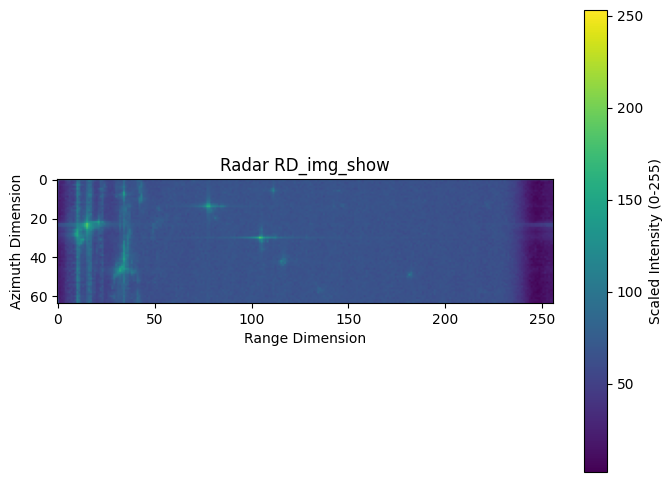

In [12]:
import matplotlib.pyplot as plt

RD_img_show = RD_img[0]

plt.figure(figsize=(8, 6))
plt.imshow(RD_img_show)
plt.title('Radar RD_img_show')
plt.xlabel('Range Dimension') # 对应宽度
plt.ylabel('Azimuth Dimension') # 对应高度
plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()


(256, 107, 3)


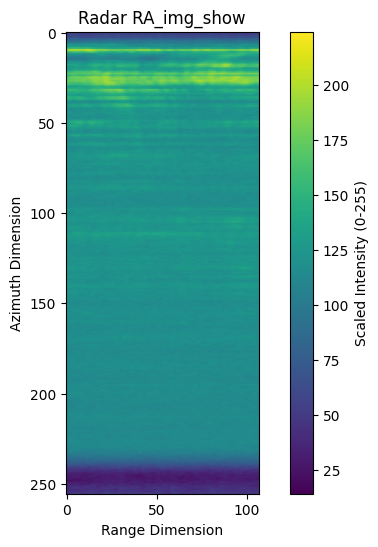

In [13]:
import matplotlib.pyplot as plt

RA_img_show = RA_img[3]
print(RA_img_show.shape)
RA_img_show 

plt.figure(figsize=(8, 6))
plt.imshow(RA_img_show)
plt.title('Radar RA_img_show')
plt.xlabel('Range Dimension') # 对应宽度
plt.ylabel('Azimuth Dimension') # 对应高度
plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()

In [14]:
sample['label_to_radar_bev_p']

tensor([[[ 0.0000, -1.0000,  0.0000, 53.0000],
         [ 2.1688,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.0000, -1.0000,  0.0000, 53.0000],
         [ 2.1688,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.0000, -1.0000,  0.0000, 53.0000],
         [ 2.1688,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.0000, -1.0000,  0.0000, 53.0000],
         [ 2.1688,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [15]:
ra = '/mnt/truenas_users/ChenHongliang/RPT-master/label0.5/pseudo_labels_ra/2019-09-16-13-13-01_000130_ra_pseudo_label_onehot.npy'
ra = np.load(ra) 

classes_to_show = [0, 1, 2, 3]
# Create figure with 2x2 subplots
plt.figure(figsize=(12, 12))
for i, class_idx in enumerate(classes_to_show, 1):
    ra_class_mask = ra[class_idx]
    
    # Create subplot
    ax = plt.subplot(2, 2, i)
    im = ax.imshow(ra_class_mask, cmap='gray')
    ax.set_title(f"RA Pseudo-Label - Class {class_idx}")
    ax.set_xlabel("Angle (pixels)")
    ax.set_ylabel("Range (pixels)")
    
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


             

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/truenas_users/ChenHongliang/RPT-master/label0.5/pseudo_labels_ra/2019-09-16-13-13-01_000130_ra_pseudo_label_onehot.npy'

(4, 256, 256)


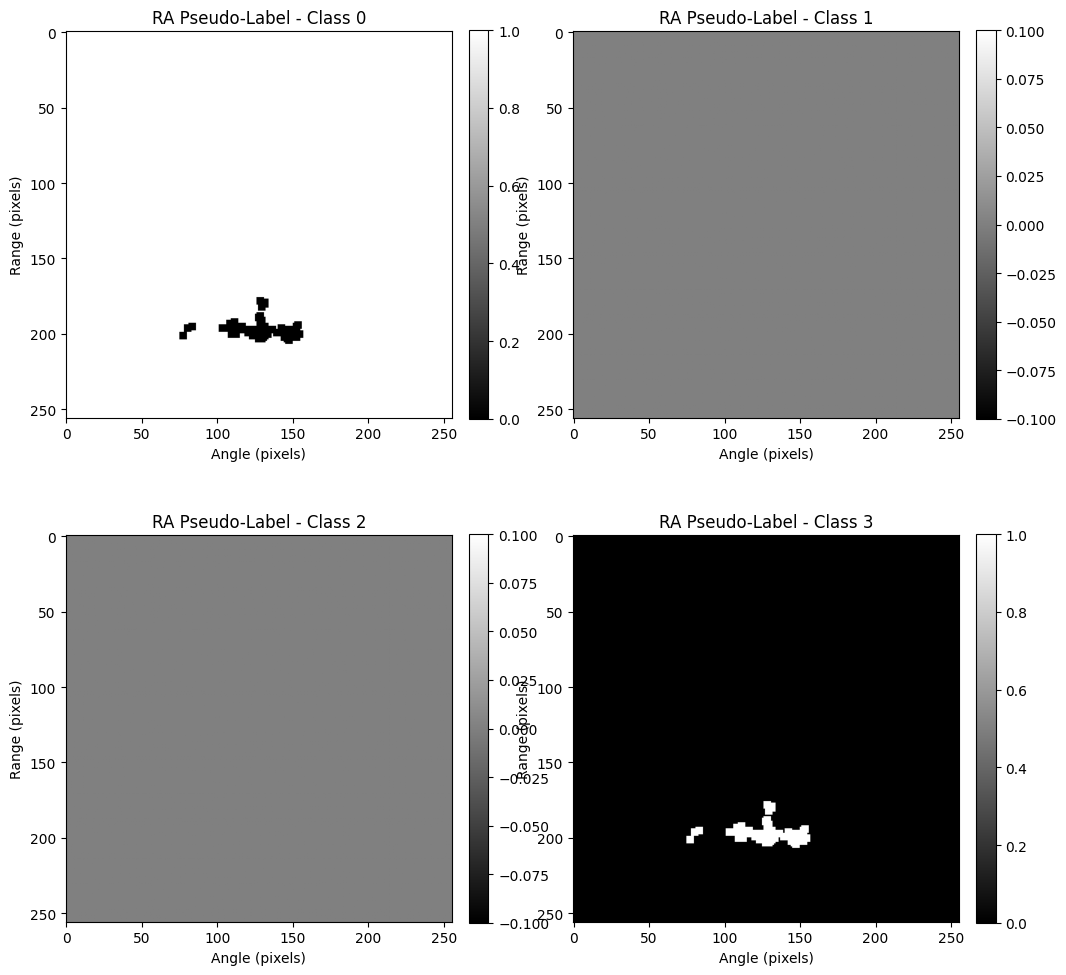

In [ ]:
ra_raw = '/mnt/truenas_datasets/Datasets_mmRadar/2022-10-CARRADA/Carrada/2019-09-16-13-13-01/annotations/dense/000130/range_angle.npy'
ra_raw = np.load(ra_raw) 
print(ra_raw.shape)

classes_to_show = [0, 1, 2, 3]
# Create figure with 2x2 subplots
plt.figure(figsize=(12, 12))
for i, class_idx in enumerate(classes_to_show, 1):
    ra_class_mask = ra_raw[class_idx]
    
    # Create subplot
    ax = plt.subplot(2, 2, i)
    im = ax.imshow(ra_class_mask, cmap='gray')
    ax.set_title(f"RA Pseudo-Label - Class {class_idx}")
    ax.set_xlabel("Angle (pixels)")
    ax.set_ylabel("Range (pixels)")
    
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [ ]:
rad_pth= '/mnt/truenas_datasets/Datasets_mmRadar/20190813_scorp_dataset/2019-08-13-14-06-44/ral_outputs_2019-08-13-14-06-44/doa_numpy/000000.npy'
RAD_complex = np.load(rad_pth) 
print(RAD_complex.shape)

# RA = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=-1),scalar=10, log_10=True)
# print("Radar RA shape:", RA.shape)

RA_img = norm2Image(RAD_complex)[..., :3]
print("Radar RA_img shape:", RA_img.shape)

# RD = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=1),scalar=10, log_10=True)
# print("Radar RD shape:", RD.shape)

# RD_img = norm2Image(RD)[..., :3]
# print("Radar RD_img shape:", RD_img.shape)


(256, 256)
Radar RA_img shape: (256, 256, 3)


(256, 256, 3)


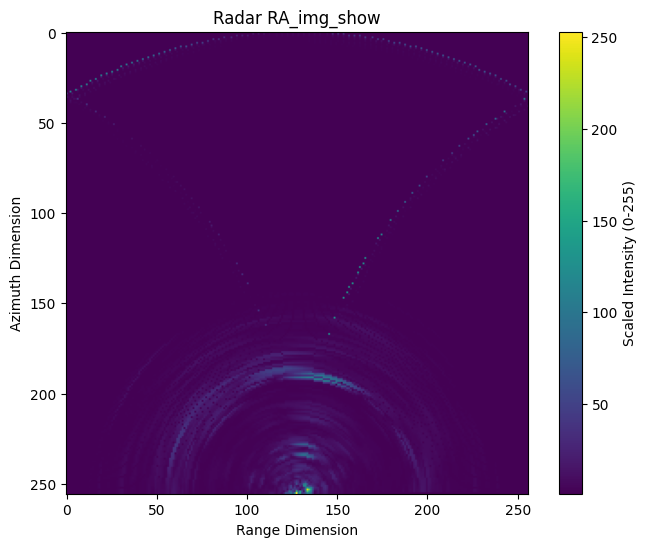

In [ ]:
import matplotlib.pyplot as plt

RA_img_show = RA_img
print(RA_img_show.shape)
RA_img_show 

plt.figure(figsize=(8, 6))
plt.imshow(RA_img_show)
plt.title('Radar RA_img_show')
plt.xlabel('Range Dimension') # 对应宽度
plt.ylabel('Azimuth Dimension') # 对应高度
plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()

In [33]:
rad_pth= '/mnt/truenas_users/ChenHongliang/RPT-master/label/pseudo_labels/2019_09_29_ONRD005/0196.npy'
RAD_complex = np.load(rad_pth) 
print(RAD_complex.shape)

RA = RAD_complex[0]
RA = np.transpose(RA, (1, 0, 2, 3))
RA_img = RA[0]
RA_img = np.transpose(RA_img, (1, 2, 0))
print("Radar RA shape:", RA_img.shape)

# RA_img = norm2Image(RA)[..., :3]
# print("Radar RA_img shape:", RA_img.shape)

# RD = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=1),scalar=10, log_10=True)
# print("Radar RD shape:", RD.shape)

# RD_img = norm2Image(RD)[..., :3]
# print("Radar RD_img shape:", RD_img.shape)

(1, 3, 16, 128, 128)
Radar RA shape: (128, 128, 3)


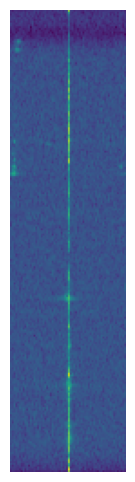

In [ ]:
import matplotlib.pyplot as plt

RD_img_show = RD_img

plt.figure(figsize=(8, 6))
plt.imshow(RD_img_show)
plt.axis('off')
plt.savefig('RADDet_RD.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.title('Radar RD_img_show')
# plt.xlabel('Range Dimension') # 对应宽度
# plt.ylabel('Azimuth Dimension') # 对应高度
# plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011153389..0.9261771].


(128, 128, 3)


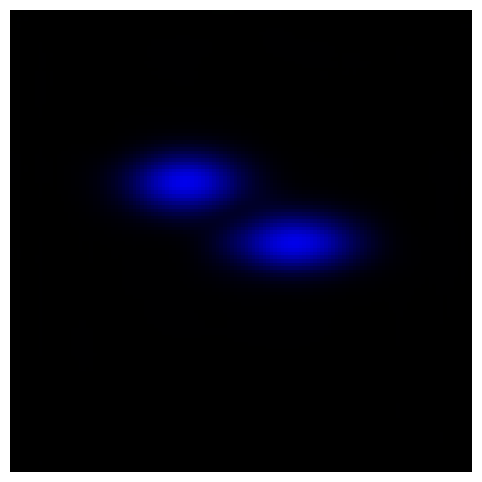

In [34]:
import matplotlib.pyplot as plt

RA_img_show = RA_img
print(RA_img_show.shape)
RA_img_show 

plt.figure(figsize=(8, 6))
plt.imshow(RA_img_show)
plt.axis('off')
plt.savefig('RADDet_RA.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.title('Radar RA_img_show')
# plt.xlabel('Range Dimension') # 对应宽度
# plt.ylabel('Azimuth Dimension') # 对应高度
# plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()

In [ ]:
rad_pth= '/mnt/truenas_datasets/Datasets_mmRadar/2022-10-CARRADA/Carrada_RAD/2020-02-28-13-13-43/RAD_numpy/000168.npy'
RAD_complex = np.load(rad_pth) 
print(RAD_complex.shape)

RA = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=-1),scalar=10, log_10=True)
print("Radar RA shape:", RA.shape)

RA_img = norm2Image(RA)[..., :3]
print("Radar RA_img shape:", RA_img.shape)

RD = getLog(getSumDim(getMagnitude1(RAD_complex,power_order=2), target_axis=1),scalar=10, log_10=True)
print("Radar RD shape:", RD.shape)

RD_img = norm2Image(RD)[..., :3]
print("Radar RD_img shape:", RD_img.shape)

(256, 256, 64)
Radar RA shape: (256, 256)
Radar RA_img shape: (256, 256, 3)
Radar RD shape: (256, 64)
Radar RD_img shape: (256, 64, 3)


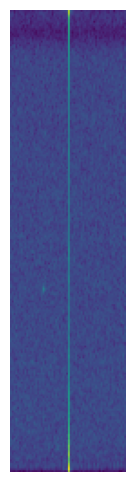

In [ ]:
import matplotlib.pyplot as plt

RD_img_show = RD_img

plt.figure(figsize=(8, 6))
plt.imshow(RD_img_show)
plt.axis('off')
plt.savefig('RD.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.title('Radar RD_img_show')
# plt.xlabel('Range Dimension') # 对应宽度
# plt.ylabel('Azimuth Dimension') # 对应高度
# plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()

(256, 256, 3)


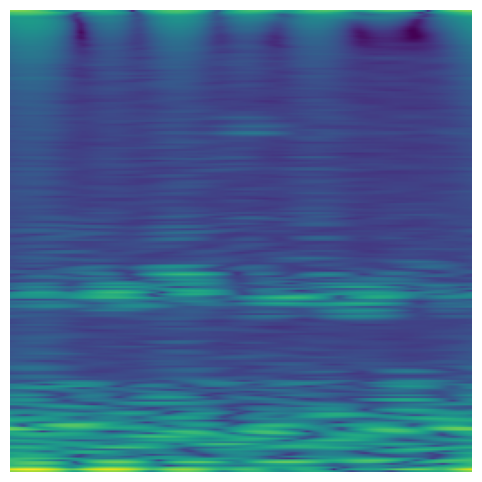

In [ ]:
import matplotlib.pyplot as plt

RA_img_show = RA_img
print(RA_img_show.shape)
RA_img_show 

plt.figure(figsize=(8, 6))
plt.imshow(RA_img_show)
plt.axis('off')
plt.savefig('RA.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.title('Radar RA_img_show')
# plt.xlabel('Range Dimension') # 对应宽度
# plt.ylabel('Azimuth Dimension') # 对应高度
# plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()

In [ ]:
rad_pth= '/mnt/truenas_datasets/Datasets_mmRadar/ROD2021/sequences/train/2019_05_29_PBMS007/RADAR_RA_H/000000_0000.npy'
RAD_complex = np.load(rad_pth) 
print(RAD_complex.shape)
RAD_complex = RAD_complex[..., 0]**2 + RAD_complex[..., 0]**2
RA = getLog(RAD_complex, scalar=10, log_10=True)
print("Radar RA shape:", RA.shape)

RA_img = norm2Image(RA)[..., :3]
print("Radar RA_img shape:", RA_img.shape)


(128, 128, 2)
Radar RA shape: (128, 128)
Radar RA_img shape: (128, 128, 3)


(128, 128, 3)


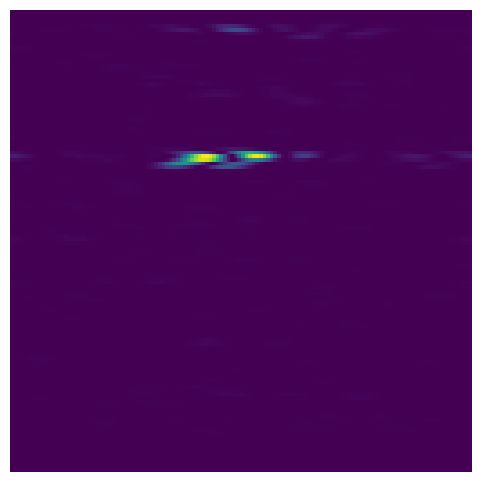

In [ ]:
import matplotlib.pyplot as plt

RA_img_show = RA_img
print(RA_img_show.shape)
RA_img_show 

plt.figure(figsize=(8, 6))
plt.imshow(RA_img_show)
plt.axis('off')
plt.savefig('RA.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.title('Radar RA_img_show')
# plt.xlabel('Range Dimension') # 对应宽度
# plt.ylabel('Azimuth Dimension') # 对应高度
# plt.colorbar(label='Scaled Intensity (0-255)')
plt.show()